# LASSO 和 岭回归（LASSO and Ridge Regression）
---

本节将展示如何使用 tensorflow 来对 $y = Ax + b$ 求解 lasso 或 ridge 回归

我们使用 iris 数据的 y = Sepal Length, x = Petal Width

In [2]:
# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [3]:
# Specify 'Ridge' or 'LASSO'
regression_type = 'LASSO'

In [4]:
# create graph
sess = tf.Session()

## 加载 iris 数据

In [5]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([x[0] for x in iris.data])

## 模型变量

In [6]:
# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

## 损失函数

In [7]:
# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso loss = L2_Loss + heavyside_step
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)
    
elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value', file=sys.stderr)

## 优化器

In [8]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

## 运行回归

In [10]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300 == 0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

Step #300 A = [[ 0.70215291]] b = [[ 4.98944473]]
Loss = [[ 0.2095314]]


Step #600 A = [[ 0.6943863]] b = [[ 5.00525713]]
Loss = [[ 0.1745003]]


Step #900 A = [[ 0.69451946]] b = [[ 5.00500393]]
Loss = [[ 0.22538194]]


Step #1200 A = [[ 0.69961774]] b = [[ 5.00454092]]
Loss = [[ 0.24080034]]


Step #1500 A = [[ 0.70270258]] b = [[ 5.01097775]]
Loss = [[ 0.22178511]]




## 提取回归结果

In [11]:
# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)

## 绘制结果

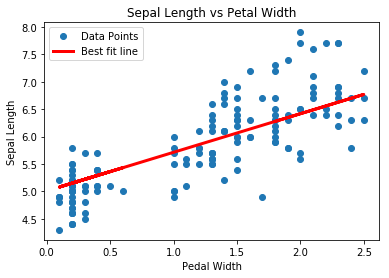

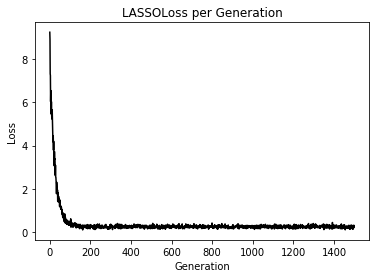

In [12]:
%matplotlib inline
# Plot the result
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Petal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + 'Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()